# Model Implementation

## Initialize Packages

In [23]:
import sys
import pandas as pd
import numpy as np
import os
import rich
import xgboost as xgb
import json
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_tweedie_deviance

In [25]:
parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)

from analysis_tool_chest.data_exploration import PredictivenessCheck
from analysis_tool_chest.model_selection import ModelEvaluation

## Load Data and Assign Predictors

### Load Base Data and Final Data

In [2]:
model_data = pd.read_csv('../backend/model_data.csv')
final_model_data = pd.read_csv('../backend/train_df_final.csv')

In [3]:
final_model_data['claim_cst_per_exposure'] = final_model_data['claimcst0'] / final_model_data['exposure']
final_model_data.head(5)

,driving_history_score,credit_score,marital_status,time_driven,area,agecat_grouped,gender,veh_color,max_power,engine_type,veh_age,veh_body,veh_value,claimcst0,numclaims,clm,exposure,claim_cst_per_exposure
0,73.0,646.516469,0.0,1.0,1.0,2.0,0.0,0.0,161,2.0,1.0,0.0,5.80,2023.198184,1,1,0.362191,5585.998969
1,88.0,635.400369,1.0,2.0,0.0,1.0,0.0,4.0,100,0.0,3.0,0.0,5.67,3600.172234,1,1,0.632068,5695.859540
2,55.0,646.463131,0.0,2.0,2.0,1.0,0.0,3.0,74,3.0,1.0,0.0,5.90,2021.144067,1,1,0.367460,5500.307127
3,98.0,645.598794,0.0,3.0,1.0,1.0,1.0,0.0,121,0.0,2.0,0.0,4.79,4006.845492,1,1,0.802184,4994.920513
4,66.0,657.348612,1.0,2.0,2.0,2.0,1.0,1.0,75,3.0,2.0,0.0,6.68,2542.953931,1,1,0.485009,5243.106060


In [6]:
# Define the list of predictors
# Create predictor list
veh_pred_lst = ['veh_value', 'veh_body', 'veh_age', 'engine_type', 'max_power', 'veh_color']
policy_pred_lst = ['gender', 'agecat', 'e_bill' ]
driving_behavior_pred_lst = ['area', 'time_of_week_driven', 'time_driven']
demo_pred_lst = ['marital_status', 'low_education_ind', 'credit_score', 'driving_history_score']
pred_lst = veh_pred_lst + policy_pred_lst + driving_behavior_pred_lst + demo_pred_lst # Split the data into training and validation sets
# pred_lst = ['engine_type', 'gender', 'credit_score', 'veh_age', 'agecat', 'area']

train_data = model_data.loc[model_data['sample'] == '1|bld']
val_data = model_data.loc[model_data['sample'] == '2|val']
rich.print( train_data.shape, val_data.shape )
train_data.head(5)

(11204, 25)
(3796, 25)

,id,fold,sample,veh_value,exposure,veh_body,veh_age,gender,area,agecat,...,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,low_education_ind,clm,numclaims,claimcst0,expected_loss
0,1,2,1|bld,5.80,0.362191,SUV,2,F,B,1,...,0,weekday,12pm - 6pm,6,646.516469,0.0,1,1,2023.198184,5585.998969
1,2,3,1|bld,5.67,0.632068,STNWG,4,F,A,2,...,0,weekend,6am - 12pm,12,635.400369,0.0,1,1,3600.172234,5695.859540
2,3,1,1|bld,5.90,0.367460,SEDAN,2,F,C,2,...,0,weekday,6am - 12pm,12,646.463131,0.0,1,1,2021.144067,5500.307127
3,4,2,1|bld,4.79,0.802184,STNWG,3,M,B,4,...,1,weekday,6pm - 12am,12,645.598794,0.0,1,1,4006.845492,4994.920513
4,5,2,1|bld,6.68,0.485009,SEDAN,3,M,C,1,...,0,weekday,6am - 12pm,12,657.348612,0.0,1,1,2542.953931,5243.106060


In [5]:
# Define features and target
target = 'expected_loss'

X_train = train_data[pred_lst].copy()
y_train = train_data[target]

# Random Forest

In [13]:
for col in X_train.select_dtypes("object"):
    X_train[col] = X_train[col].astype("category").cat.codes

In [ ]:
# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=300,      # number of trees
    max_depth=None,        # no depth limit (fully grown trees)
    random_state=42,
    n_jobs=1
)

rf.fit(X_train, y_train)

# In-sample predictions
y_pred = rf.predict(X_train)

# Evaluate on training data
rmse = root_mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("Training Model Metrics")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

Training Model Metrics
RMSE: 1479.17
MAE: 671.65
R²: 0.859


# XGBoost

## Frequency-Severity Modeling

In [15]:
# XGBoost Tweedie Regression with Cross-Validation Early Stopping and Native Categorical Support

final_preds = [
    'driving_history_score', # was supposed to drop, but this feels important for insurance
    'credit_score',
    # 'low_education_ind', # dropped based on results of varclushi
    'marital_status',
    'time_driven',
    'area',
    'agecat_grouped',
    'gender',
    'veh_color',
    'max_power',
    'engine_type',
    'veh_age',
    'veh_body',
    'veh_value' # were supposed to drop this but it doesn't make much sense to do
]

# Define features and target
y = final_model_data['claimcst0'].astype(float)
exposure = final_model_data['exposure'].astype(float).clip(lower=1e-12)
X = final_model_data[final_preds].copy()
# weights = train_data['exposure']  # Assuming exposure is in years, convert to months

In [16]:
# XGBoost DMatrix with offset
dtrain = xgb.DMatrix(
    X,
    label=y,
    base_margin=np.log(exposure)   # log exposure offset
)

# Define XGBoost parameters for Tweedie regression
params = {
    'objective': 'reg:tweedie',
    'eval_metric': 'tweedie-nloglik@1.5',
    'tweedie_variance_power': 1.5,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1.0,
    'alpha': 0.0,
    'nthread': -1,
    'seed': 42,
    'tree_method': 'hist',
}

# Cross-validation with early stopping
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=5000,
    nfold=5,  # 5-fold cross-validation
    early_stopping_rounds=50,
    seed=42,
    verbose_eval=50
 )

# The best number of boosting rounds is:
best_num_boost_round = len(cv_results)
print(f"Best num_boost_round from CV: {best_num_boost_round}")

[0]	train-tweedie-nloglik@1.5:1121.95791+28.99751	test-tweedie-nloglik@1.5:1121.95260+115.99175
[50]	train-tweedie-nloglik@1.5:683.18697+17.58049	test-tweedie-nloglik@1.5:683.52632+70.59181
[100]	train-tweedie-nloglik@1.5:419.00228+10.67815	test-tweedie-nloglik@1.5:421.28415+42.83806
[150]	train-tweedie-nloglik@1.5:261.80495+6.48022	test-tweedie-nloglik@1.5:267.62798+27.34394
[200]	train-tweedie-nloglik@1.5:169.99572+3.91751	test-tweedie-nloglik@1.5:178.79596+18.11413
[250]	train-tweedie-nloglik@1.5:118.17867+2.50635	test-tweedie-nloglik@1.5:129.28382+12.70322
[300]	train-tweedie-nloglik@1.5:90.60521+1.68353	test-tweedie-nloglik@1.5:103.28856+9.60443
[350]	train-tweedie-nloglik@1.5:76.74897+1.27692	test-tweedie-nloglik@1.5:90.18820+8.00078
[400]	train-tweedie-nloglik@1.5:69.88949+1.06340	test-tweedie-nloglik@1.5:84.17284+7.05087
[450]	train-tweedie-nloglik@1.5:66.19790+1.01757	test-tweedie-nloglik@1.5:81.67534+6.77171
[500]	train-tweedie-nloglik@1.5:63.89386+1.00609	test-tweedie-nlogli

In [17]:
# Train final model on all data using best_num_boost_round
model = xgb.train(
    params,
    dtrain,
    # num_boost_round=500
    num_boost_round=best_num_boost_round
 )

In [ ]:
train_pred = model.predict(dtrain)
final_model_data['pred_per_exposure'] = train_pred 
final_model_data['pred'] = final_model_data['pred_per_exposure'] * final_model_data['exposure']  # Scale by exposure
rescale_factor_2 = final_model_data['claimcst0'].sum() / final_model_data['pred'].sum()
final_model_data['pred_rescale'] = final_model_data['pred'] * rescale_factor_2

2.645556145032545


Top Lift: 3.4127
Gini: 0.6682
R^2: 0.1380
RMSE: 1722.59
MAE: 685.50


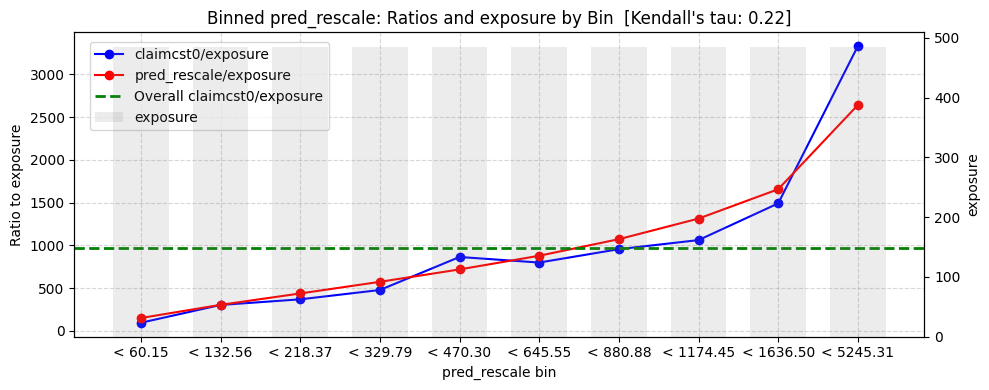

In [ ]:
# Select training samples for predictiveness check
data = final_model_data

# Define variables
exp_var = 'exposure'
pred_var = 'pred_rescale'
var_1 = 'claimcst0'
var_2 = 'pred_rescale'
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

pc.binning(nbins=nbins)
pc.aggregate()

# Compute top lift
pc.top_lift()

# Compute R^2, RMSE, and MAE
me = ModelEvaluation(data[var_1], data[var_2])
gini = me.gini()
rmse = me.rmse()
mae = me.mae()

# Print results
print(f"Top Lift: {pc.top_lift:.4f}")
print(f"Gini: {gini:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
pc.plot(figsize=(10, 4))

1. Top Lift = 3.41

This means:

The top 10% of customers ranked by your model have 3.41× higher average loss than the portfolio overall.

That is very strong uplift.

In pricing/underwriting terms:

Your model sharply concentrates high-risk policies at the top of the predicted distribution.

If used in segmentation, the high-risk group would contain a disproportionate share of actual losses.

This is excellent for identifying high-loss segments and building risk tiers.

2. Gini = 0.6682

A Gini of 0.67 is exceptionally high for an insurance severity or pure-premium model.

Interpretation:

The model improves risk ranking by 66.8% relative to random — indicating excellent discriminatory power.

This means:

The model is extremely good at sorting customers from low to high expected loss.

It provides highly actionable ranking for underwriting, risk segmentation, and pricing.

Even if absolute predictions are noisy (due to claim rarity), the ordering is outstanding.

3. RMSE = 1722.59 & MAE = 685.50

Interpretation:

On average, the prediction misses the true claim cost per exposure by $685.

Large errors occur due to the heavy tail (RMSE is much larger than MAE).

This is exactly what you expect:

Losses are infrequent but severe when they occur.

RMSE is dominated by rare high-cost claims.

MAE represents a more realistic “average miss”.


In [33]:
# Model metrics on Training Data

# MAE
y_pred = model.predict(dtrain)
mae = mean_absolute_error(y, y_pred)
print(f"Training MAE: {mae:.2f}")

# Tweedie Deviance
tweedie_dev = mean_tweedie_deviance(
    y_true=y,
    y_pred=y_pred,
    power=1.5    # same as model.tweedie_variance_power
)
print(f"Training Tweedie Deviance: {tweedie_dev:.2f}")

# Gini Coefficient


Training MAE: 593.67
Training Tweedie Deviance: 87.47


In [ ]:
# Model metrics on Validation Data


In [18]:
# calculate feature importance
importance = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)
importance_df


,Feature,Importance
10,veh_age,968.746155
0,driving_history_score,967.222046
1,credit_score,941.158508
5,agecat_grouped,930.930054
2,marital_status,902.729736
11,veh_value,901.950134
8,max_power,894.542175
7,veh_color,893.839233
4,area,826.723389
3,time_driven,772.186157


## Risk Segmentation

### Quantiles

In [19]:
train_data['predicted_expected_loss'] = y_pred

train_data.head()

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_8963/2966020220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['predicted_expected_loss'] = y_pred


,id,fold,sample,veh_value,exposure,veh_body,veh_age,gender,area,agecat,...,time_of_week_driven,time_driven,trm_len,credit_score,low_education_ind,clm,numclaims,claimcst0,expected_loss,predicted_expected_loss
0,1,2,1|bld,5.80,0.362191,SUV,2,F,B,1,...,weekday,12pm - 6pm,6,646.516469,0.0,1,1,2023.198184,5585.998969,4190.744101
1,2,3,1|bld,5.67,0.632068,STNWG,4,F,A,2,...,weekend,6am - 12pm,12,635.400369,0.0,1,1,3600.172234,5695.859540,5273.055427
2,3,1,1|bld,5.90,0.367460,SEDAN,2,F,C,2,...,weekday,6am - 12pm,12,646.463131,0.0,1,1,2021.144067,5500.307127,4220.612971
3,4,2,1|bld,4.79,0.802184,STNWG,3,M,B,4,...,weekday,6pm - 12am,12,645.598794,0.0,1,1,4006.845492,4994.920513,3422.488947
4,5,2,1|bld,6.68,0.485009,SEDAN,3,M,C,1,...,weekday,6am - 12pm,12,657.348612,0.0,1,1,2542.953931,5243.106060,3485.267952


In [20]:
train_data["expected_loss"].quantile([0.33, 0.66])

0.33    0.0
0.66    0.0
Name: expected_loss, dtype: float64

### Fixed Thresholds

### KMeans Clustering

## Save Altered Data

In [ ]:
model_data.to_csv('../project/model_data.csv', index=False)
inference_data.to_csv('../project/inference_data.csv', index=False)

## Export Model Artifacts

In [24]:
# 1) Save the trained RandomForestRegressor
joblib.dump(rf, "../project/models/rf_model.pkl")

# 2) Save the exact feature column order used to fit the model
feature_columns = list(X_train.columns)  # if you trained with a DataFrame
with open("../project/models/feature_columns.json", "w") as f:
    json.dump(feature_columns, f)

# 3) (Optional) Create simple risk cutoffs from training predictions